# Heuristic Algorithms for Automated Data Extraction

In [18]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import scipy.ndimage as ndimage
# try:
#     import Image
# except ImportError:
from PIL import Image
import pytesseract as tes

import sys
sys.path.insert(0, './functions')
import ocr_tools
import find_axes
from thresholding import adaptive_thresh

print('All packages loaded')

All packages loaded


<IPython.core.display.Javascript object>


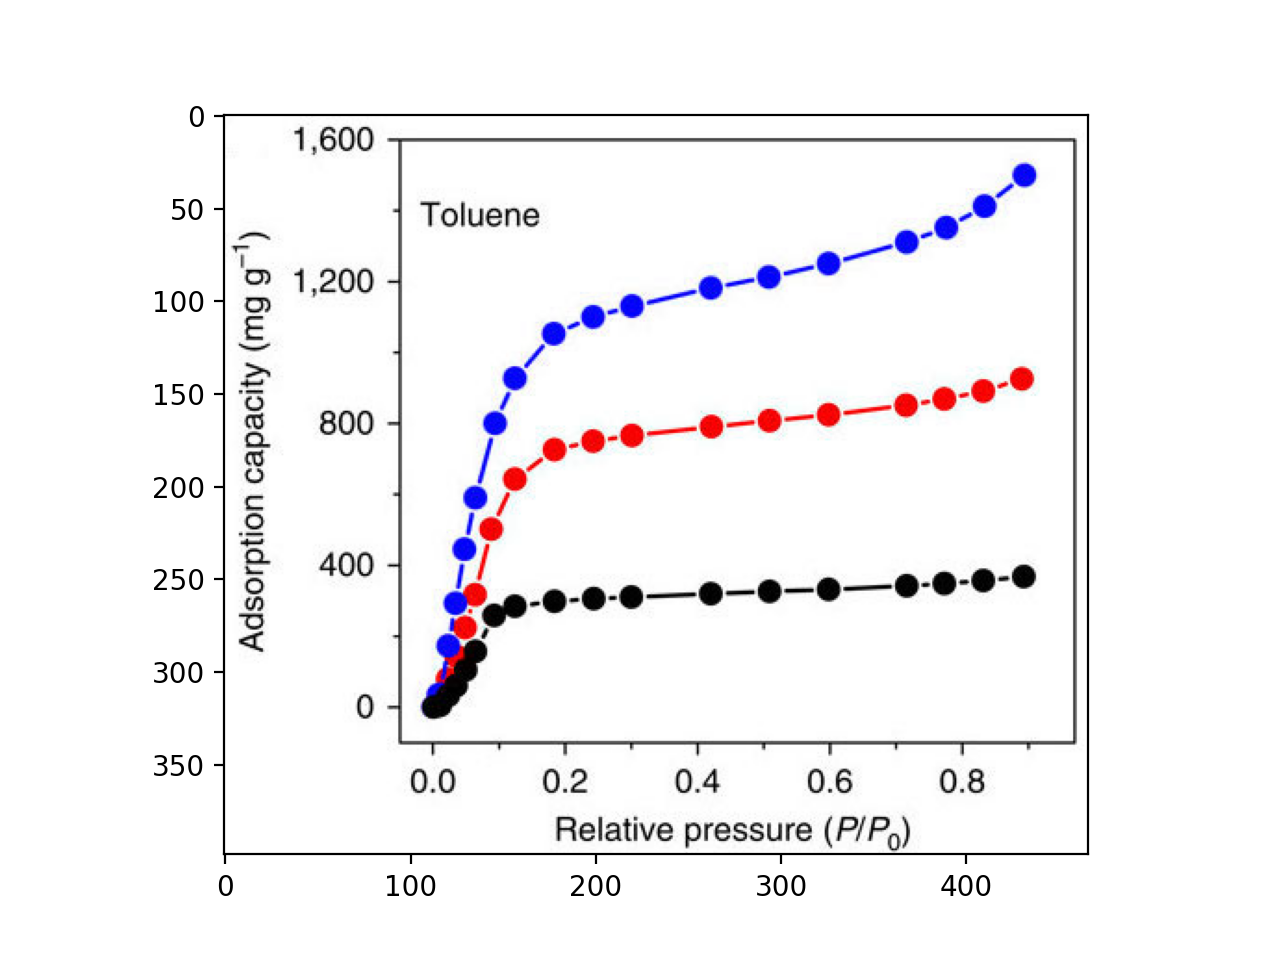

In [2]:
example = 'examples/example101.jpg'
img = cv2.imread(example)
m,n,p=img.shape

%matplotlib notebook
plt.figure()
implot = plt.imshow(img)

## This is our starting point

We would like to find the axes, calibrate them from pixel to data space, find the data and extract it.

<IPython.core.display.Javascript object>


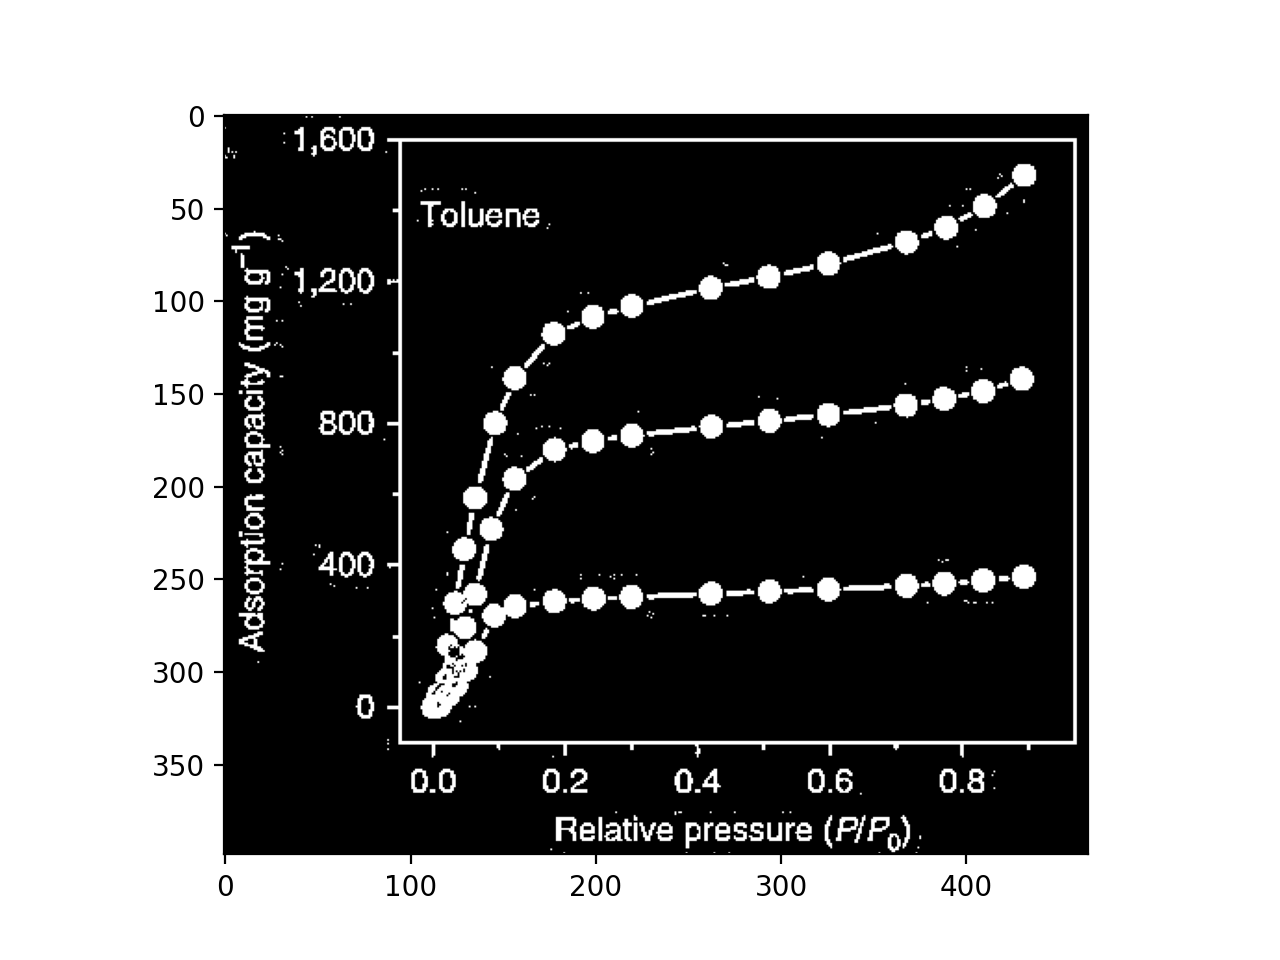

In [3]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# bw4 = adaptive_thresh(gray)
nbw = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,11,5)
# nbw = (255-bw4)

%matplotlib notebook
plt.figure()
implot = plt.imshow(nbw, cmap='gray')

# Finding Axes

Now we are going to engineer an axis feature score, for example, the x-axis:

[cos^2, fractional length, fractional y-coord (or x coord for y axis)]

"How horizontal is this line segment?"
"How long is it relative to the image size?"
"Where is it in the image?"

In [4]:
linesP = cv2.HoughLinesP(nbw,1,np.pi/2,2, minLineLength = nbw.shape[1]/10, maxLineGap = 3)
print('Hough Transform complete')
import find_axes
# print(linesP)
xax = find_axes.get_xaxis(np.reshape(linesP,(-1,4)),nbw)
print('x axis')
print(xax)
yax = find_axes.get_yaxis(np.reshape(linesP,(-1,4)),nbw)
print('y axis')
print(yax)

Hough Transform complete
x axis
[ 96 338 457 338]
y axis
[ 94 338  94  13]


<IPython.core.display.Javascript object>


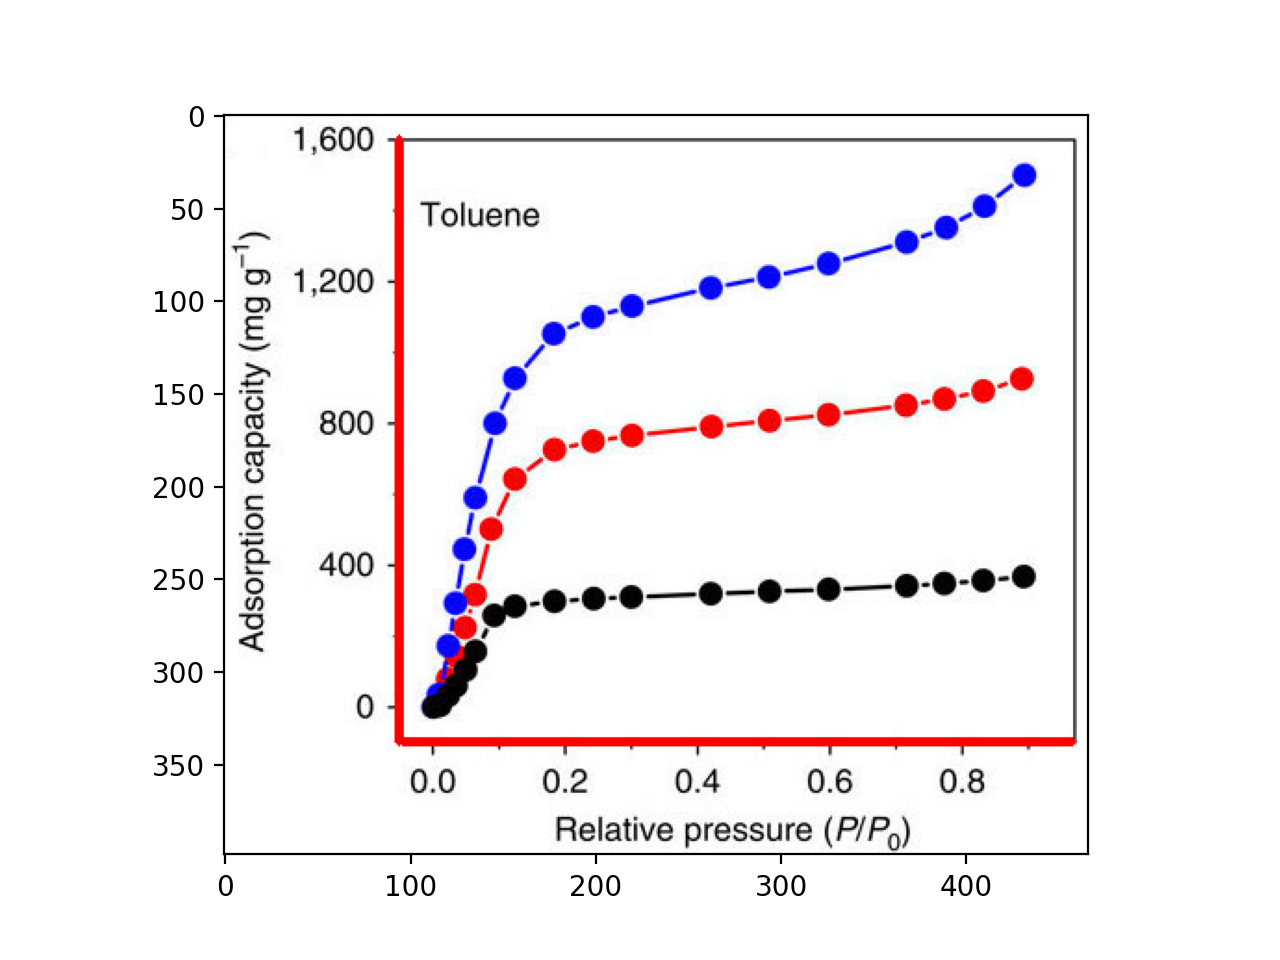

In [5]:
imlabel = img.copy();
cv2.line(imlabel,(xax[0],xax[1]),(xax[2],xax[3]),(255,0,0),4)
cv2.line(imlabel,(yax[0],yax[1]),(yax[2],yax[3]),(255,0,0),4)

%matplotlib notebook
plt.figure()
implot = plt.imshow(imlabel)
implot.set_cmap('gray')

## Locating Ticks and Tick Labels

It's actually easier to start by finding the labels - in fact, in many cases it's not necessary to even find the ticks at all.

OCR is difficult. Tesseract is the best open source library for it, but it's not a panacea. We can help it by first isolating the region from which we'd like to extract text.

<IPython.core.display.Javascript object>


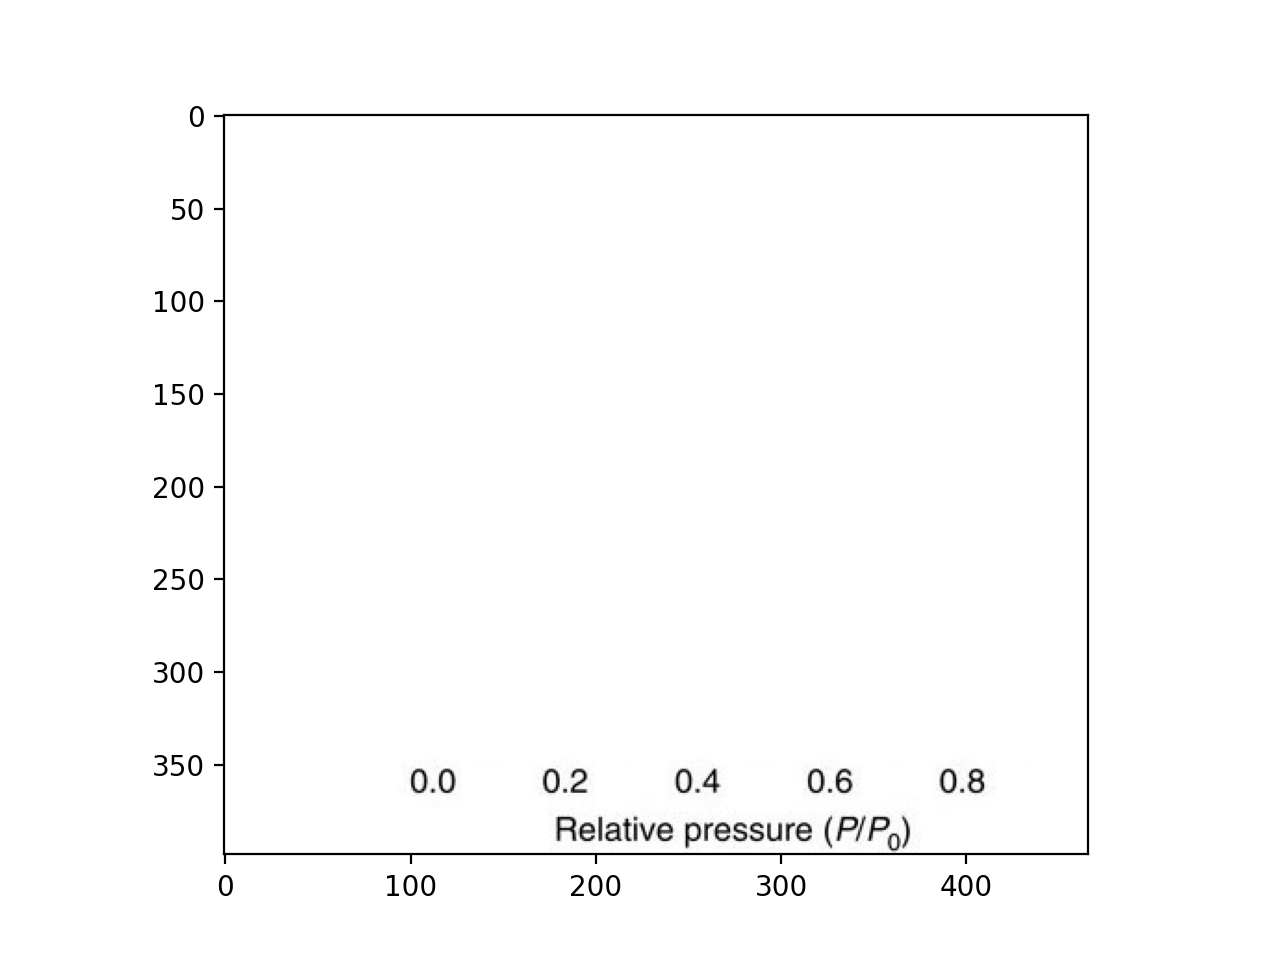

In [6]:
# Find where the x-ticks stop and crop the text image to be below that
below_xax_bw = np.zeros([m,n]).astype('uint8')
below_xax_bw[xax[1]:,:]=nbw[xax[1]:,:]
row_sums = below_xax_bw.sum(axis=1)
row_sums[0:xax[1]] = 1000
row_sums_list = row_sums.tolist()
text_crop_ind = row_sums_list.index(0)
text_crop_ind

xTextImg = np.ones([m,n,p]).astype('uint8')*255
xTextImg[text_crop_ind+1:,:,:]=img[text_crop_ind+1:,:,:]

cv2.imwrite('temp/xtext.png',xTextImg)
%matplotlib notebook
plt.figure()
implot = plt.imshow(xTextImg)

### Here, we perform OCR, then pick out only the numbers.

In [7]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [15]:
import ocr_tools
xocr = tes.image_to_data(Image.open("./temp/xtext.png"), output_type=tes.Output.DICT)
print('OCR complete')

OCR complete


In [19]:
pd.DataFrame(xocr)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,466,399,-1,
1,2,1,1,0,0,0,92,349,318,48,-1,
2,3,1,1,1,0,0,92,349,318,48,-1,
3,4,1,1,1,1,0,92,349,318,26,-1,
4,5,1,1,1,1,1,92,349,33,26,96,0.0
5,5,1,1,1,1,2,172,349,22,26,95,0.2
6,5,1,1,1,1,3,244,353,22,13,96,0.4
7,5,1,1,1,1,4,315,349,22,26,95,0.6
8,5,1,1,1,1,5,386,353,24,13,83,0.8
9,4,1,1,1,2,0,179,379,191,18,-1,


In [8]:
words = ocr_tools.clean_ocr_results(xocr)
numbers = [w for w in words if is_number(w[0])]

for w in numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
xt_labels = np.array(numbers)

%matplotlib notebook
plt.figure()
for w in numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)
implot = plt.imshow(imlabel)

TypeError: image_to_string() got an unexpected keyword argument 'boxes'

### Now, we use another Hough transform to find ticks, and match them with their nearest label.

<IPython.core.display.Javascript object>


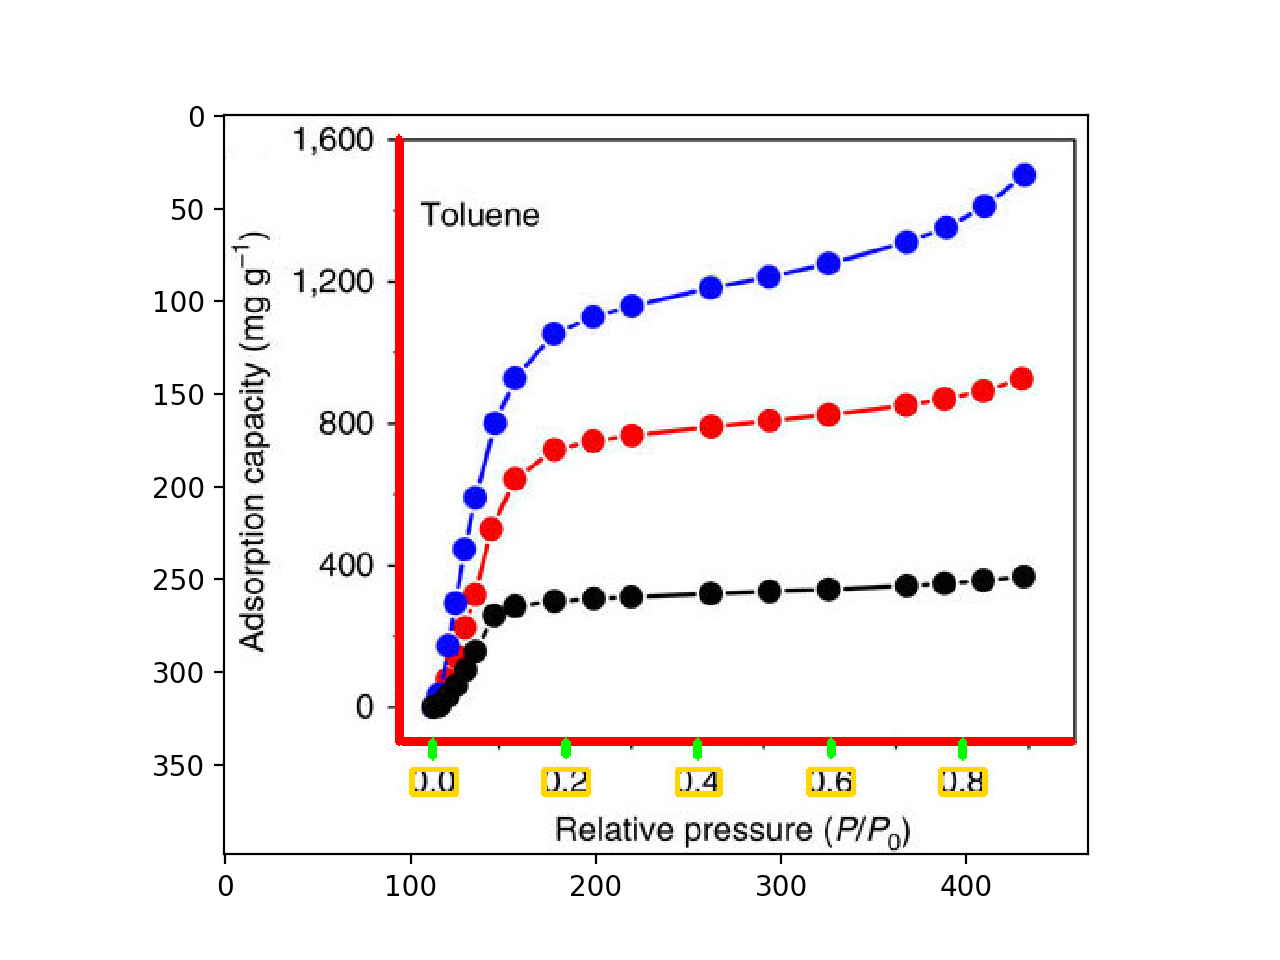

In [9]:
xt_dirty = find_axes.get_xticks(nbw,xax,tickMargin=11,minTickLen=0,maxGap=0)
xt_list=xt_dirty.tolist()
xt_match = find_axes.match_xticks(numbers,xt_list)
xt_pts = [xt_list[i] for i in xt_match]

%matplotlib notebook
plt.figure()
for x1,y1,x2,y2 in xt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),4)
implot = plt.imshow(imlabel)

## Convert x-axis from pixel space to data space with regression

In [10]:
xt_pts_array = np.array(xt_pts)
xt_pts_array[:,0].reshape(-1,1)
print('X Axis in pixels')
print(xt_pts_array[:,0].reshape(-1,1))

xt_labels[:,0].reshape(-1,1)
print('X Axis in Data')
print(xt_labels[:,0].reshape(-1,1))

from sklearn import datasets, linear_model
regrx = linear_model.LinearRegression(fit_intercept=True)
regrx.fit(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))

# The coefficients
print('Coefficients: \n', regrx.coef_)
print('Intercept: \n', regrx.intercept_)

X Axis in pixels
[[112]
 [184]
 [255]
 [327]
 [398]]
X Axis in Data
[[0. ]
 [0.2]
 [0.4]
 [0.6]
 [0.8]]
Coefficients: 
 [[0.00279719]]
Intercept: 
 [-0.31384196]


## For Y-Ticks, the rotated text breaks pytesseract OCR

To solve this, we isolate the text, rotate it, remove the axis label, rotate back, then perform OCR.

cropping y-axis region


<IPython.core.display.Javascript object>


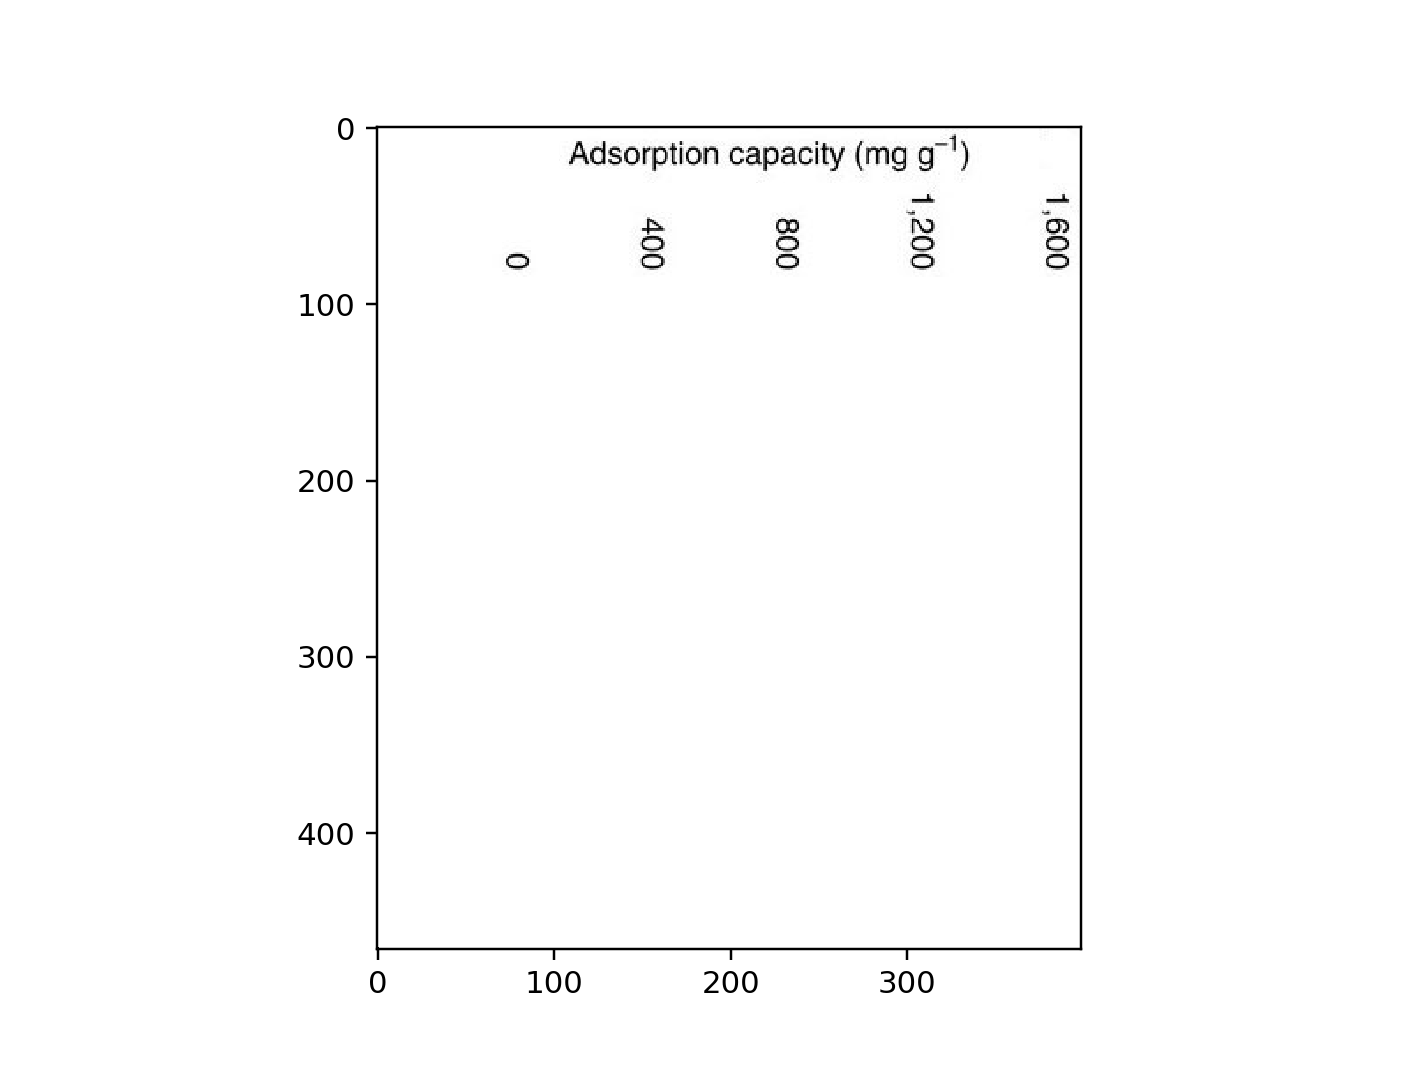

In [115]:
# Find where the y-ticks stop and crop the text image to be left of that
left_yax_bw = np.zeros([m,n]).astype('uint8')
left_yax_bw[:yax[0],:]=nbw[:yax[0],:]
col_sums = left_yax_bw.sum(axis=0)
col_sums[yax[0]:] = 1000
col_zeros=np.where(col_sums==0)[0]
y_crop_ind=col_zeros[-1]
print('cropping y-axis region')

yTextImg = np.ones([m,n,p]).astype('uint8')*255
yTextImg[:,0:y_crop_ind-1,:]=img[:,0:y_crop_ind-1,:]
cv2.imwrite('temp/ytext.png',yTextImg)

%matplotlib notebook
plt.figure()
yTextRot = ndimage.interpolation.rotate(yTextImg, -90)
cv2.imwrite('temp/ytextrot.png',yTextRot)
implot = plt.imshow(yTextRot)
implot.set_cmap('gray')



Y-Axis OCR complete


<IPython.core.display.Javascript object>


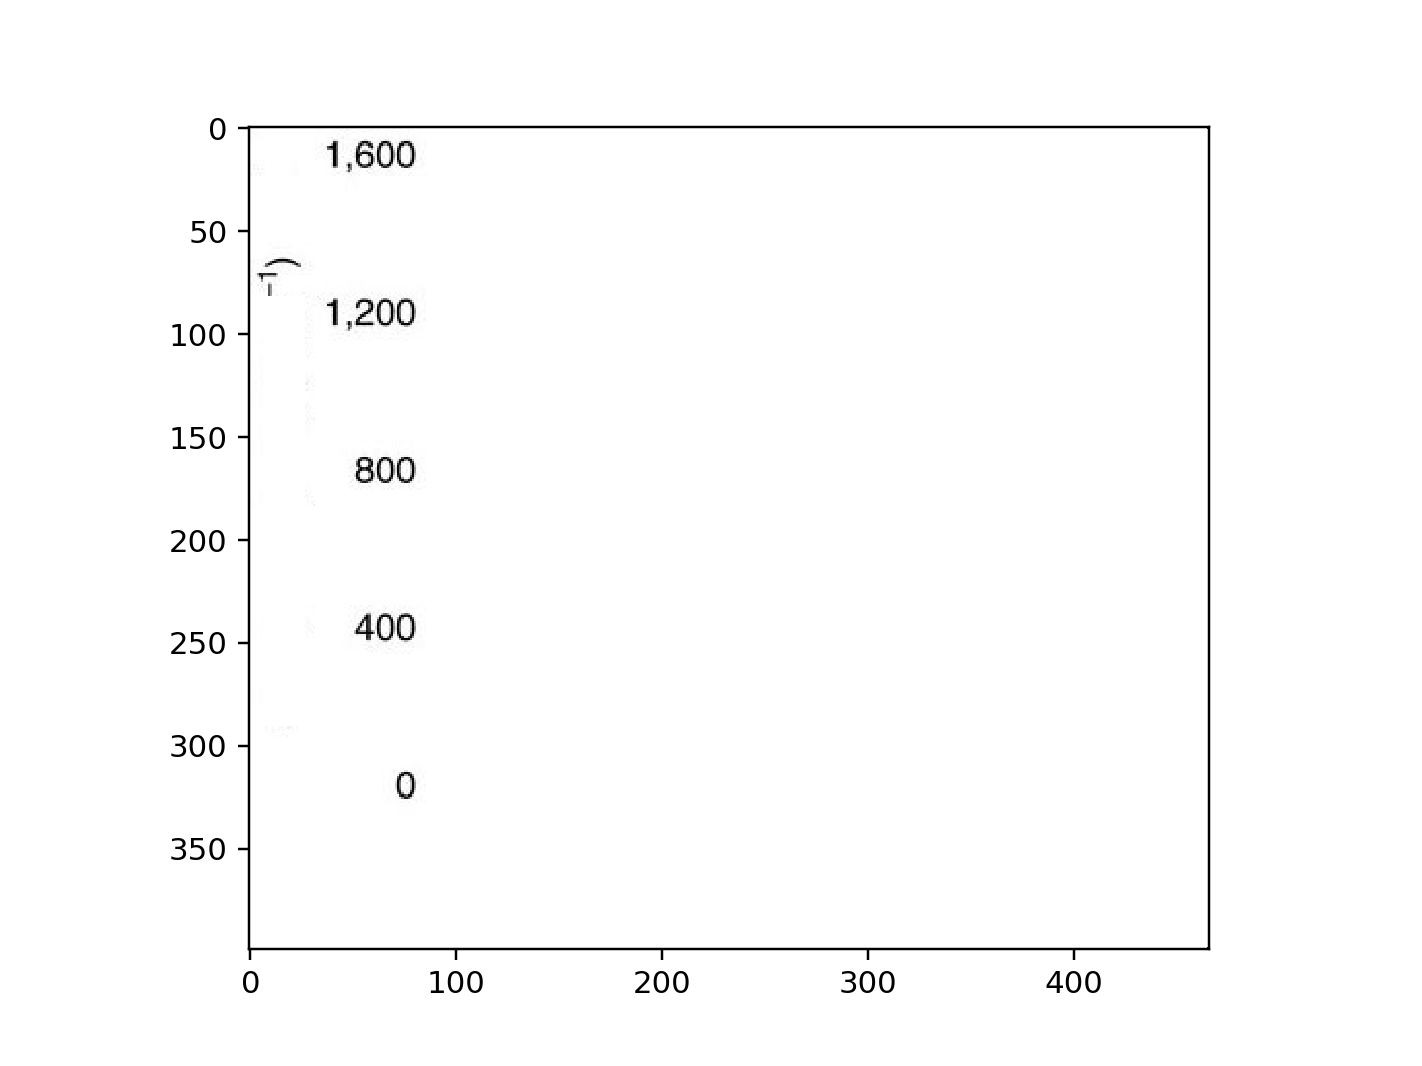

In [55]:
yRotOcr = tes.image_to_string(Image.open('temp/ytextrot.png'),boxes=True)
print('Y-Axis OCR complete')
yrot_words = ocr_tools.clean_ocr_results(yRotOcr,charspace=15,neg_charspace=-3)
word_length = [len(i[0]) for i in yrot_words]
longest_word = np.array(word_length).argmax()
lwbox = yrot_words[longest_word]
x1 = lwbox[1]-1
y1 = lwbox[2]-1
x2 = lwbox[3]+1
y2 = lwbox[4]+1
y1 = n-y1
y2 = n-y2
yTextRot[y2:y1+1,x1:x2+1,:] = np.ones([y1-y2+1,x2-x1+1,3]).astype('uint8')*255
yText_Clean = ndimage.interpolation.rotate(yTextRot, 90)

%matplotlib notebook
plt.figure()
implot = plt.imshow(yText_Clean)

### Conventional OCR

<IPython.core.display.Javascript object>


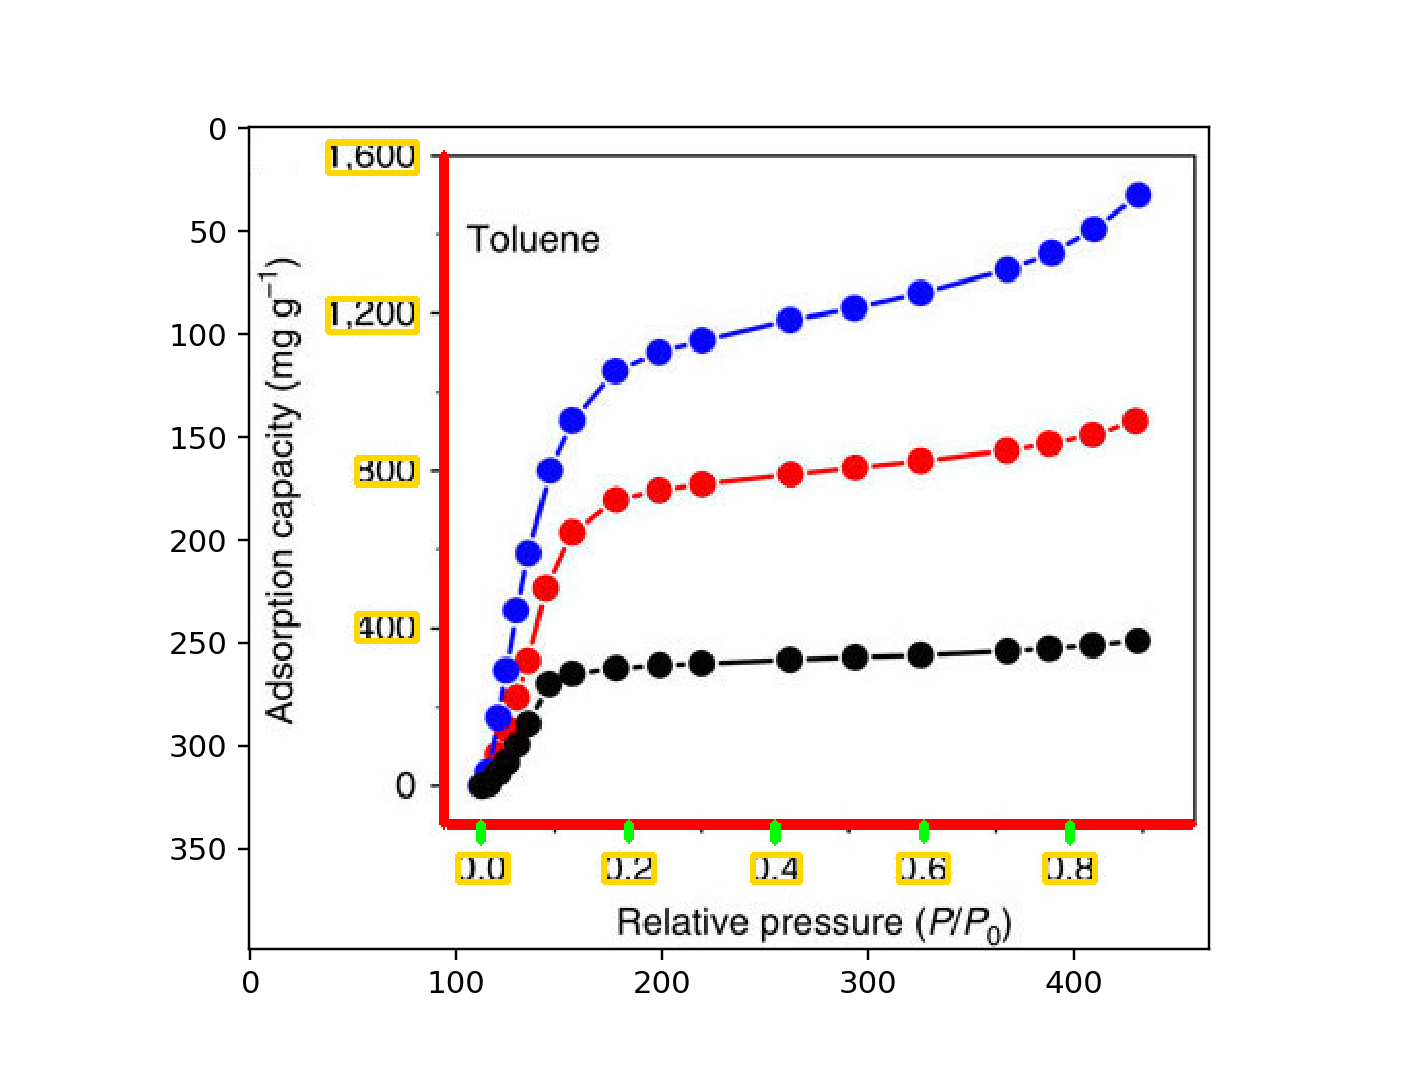

In [116]:
cv2.imwrite('temp/ytextclean.png',yText_Clean)
yocr = tes.image_to_string(Image.open('temp/ytextclean.png'),boxes=True)
yl_ocr = ocr_tools.clean_ocr_results(yocr)
yt_numbers = [w for w in yl_ocr if is_number(w[0])]
for w in yt_numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
yt_label_array = np.array(yt_numbers)

%matplotlib notebook
plt.figure()
for w in yt_numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)
implot = plt.imshow(imlabel)

<IPython.core.display.Javascript object>


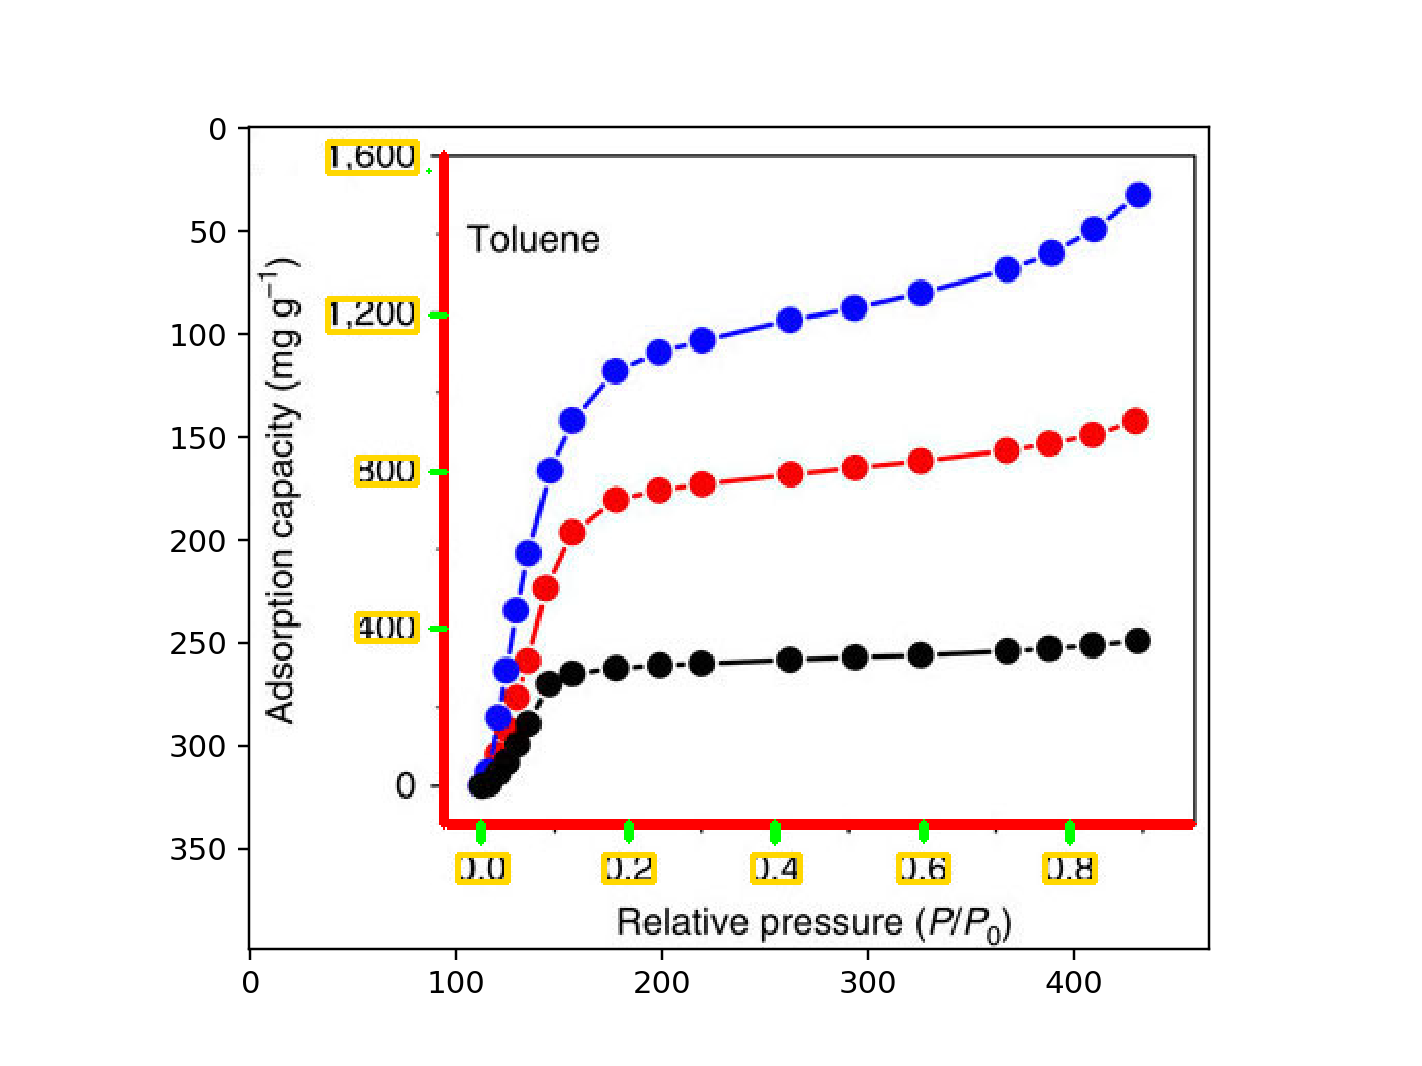

In [117]:
yt_dirty = find_axes.get_yticks(nbw,yax,tickMargin=11,minTickLen=0,maxGap=2)
yt_list=yt_dirty.tolist()
yt_match = find_axes.match_xticks(yt_numbers,yt_list)
yt_pts = [yt_list[i] for i in yt_match]
yt_pts

%matplotlib notebook
plt.figure()
for x1,y1,x2,y2 in yt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)
implot = plt.imshow(imlabel)

In [118]:
yt_pts_array = np.array(yt_pts)
print('y axis pixels')
print(yt_pts_array[:,1].reshape(-1,1))
print('y axis data')
print(yt_label_array[:,0].reshape(-1,1))

regry = linear_model.LinearRegression(fit_intercept=True)
regry.fit(yt_pts_array[:,1].reshape(-1,1), yt_label_array[:,0].reshape(-1,1))

# The coefficients
print('Coefficients: \n', regry.coef_)
print('Intercept: \n', regry.intercept_)

y axis pixels
[[ 21]
 [ 91]
 [167]
 [243]]
y axis data
[[1600.]
 [1200.]
 [ 800.]
 [ 400.]]
Coefficients: 
 [[-5.38872145]]
Intercept: 
 [1703.22814917]


## Finally, extract the data.

In more advanced approaches, a trained CNN can be used to identify data markers. Here, we can achieve similar performance with binary erosion. Multiple series with different colors can be dealt with through clustering.

In [119]:
num_series = 4

from color_series_scrape import color_series_scrape
pix_pts, ROI = color_series_scrape(example, [[xax[0],xax[2]]],[[yax[3],yax[1]]], n_colors=num_series)
print('Done clustering')

import skimage.filters
from cluster_data import cluster_colorspace_km, cluster_colorspace_ms, return_series
im_recon, im_label = cluster_colorspace_km(ROI[0], num_series)
labels_as_ims = return_series(im_label)

KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image
Done clustering
KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


<IPython.core.display.Javascript object>


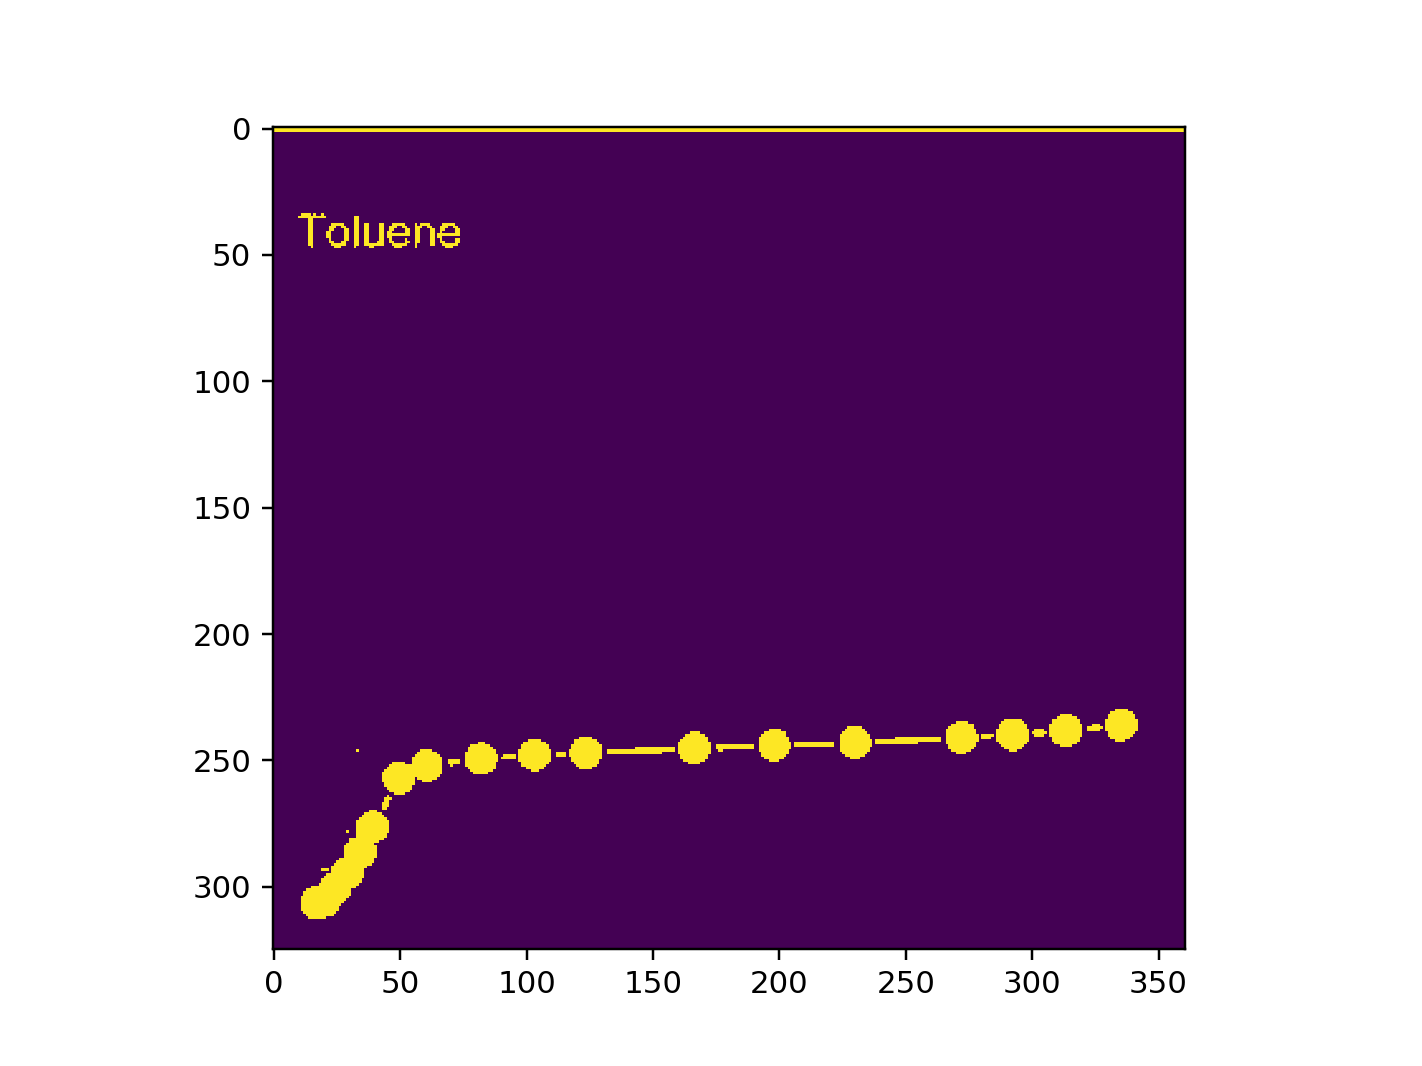

In [120]:
%matplotlib notebook
plt.figure()
plt.imshow(labels_as_ims[2])

<IPython.core.display.Javascript object>


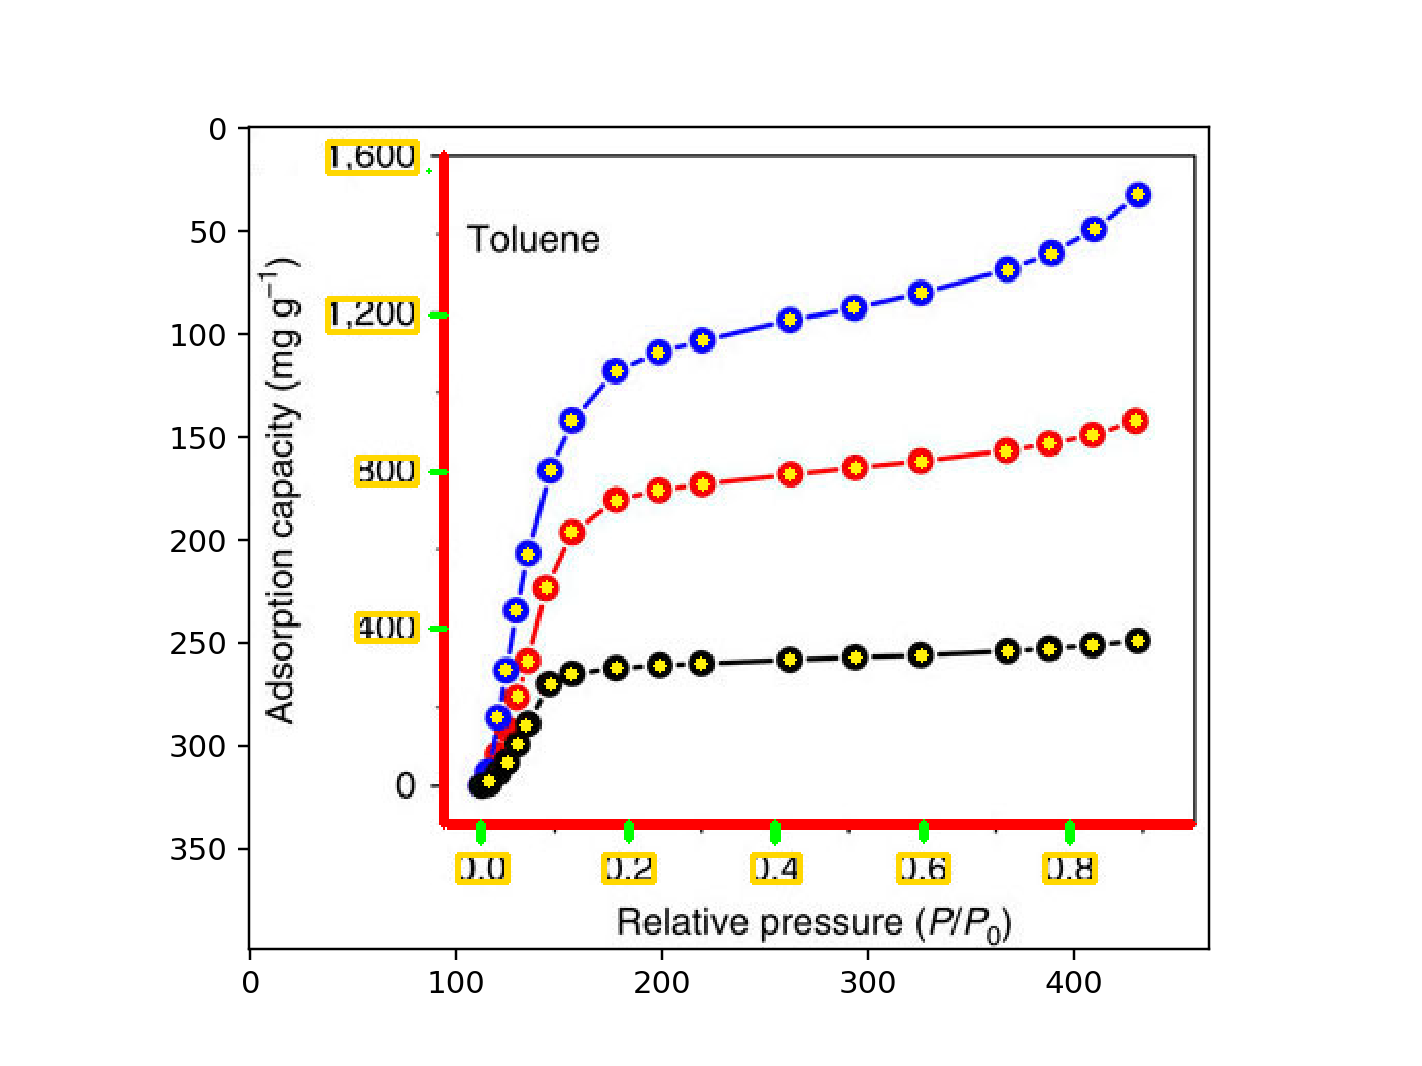

In [121]:
imlabel4 = imlabel.copy()
pp_list = []
for series in pix_pts[0]:
    s_list = []
    for tup in series:
        x = int(round(tup[1]))+xax[0]
        y = int(round(tup[0]))+yax[3]
        s_list.append([x,y])
    pp_list.append(s_list)

pp_list

for series in pp_list:
    for pt in series:
        cv2.circle(imlabel4,(pt[0],pt[1]), 3, (255,240,10), -1)
        
%matplotlib notebook
lastplot = plt.imshow(imlabel4)

## ... and convert the pixel values to the units of the axes

In [122]:
data_list = []
for series in pp_list:
    ser_list = []
    for pt in series:
        xdata = pt[0]*regrx.coef_+regrx.intercept_
        ydata = pt[1]*regry.coef_+regry.intercept_
        ser_list.append([xdata[0,0],ydata[0,0]])
    data_list.append(ser_list[::-1])

[[format(j[0],'.3f'),format(j[1],'.3f')] for j in data_list[0]]

[['0.050', '215.941'],
 ['0.064', '307.549'],
 ['0.089', '501.543'],
 ['0.123', '647.039'],
 ['0.184', '727.870'],
 ['0.240', '754.813'],
 ['0.302', '770.979'],
 ['0.419', '797.923'],
 ['0.509', '814.089'],
 ['0.598', '830.255'],
 ['0.713', '857.199'],
 ['0.771', '878.754'],
 ['0.830', '900.309'],
 ['0.889', '938.030']]